## Download Dataset

In [ ]:
!nvidia-smi

Fri Dec  5 08:27:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 Ti     On  |   00000000:01:00.0 Off |                  N/A |
| 32%   38C    P8             29W /  300W |       0MiB /  16303MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from IPython.display import clear_output

In [ ]:
%pip install matplotlib
%pip install gdown
clear_output()
print("Packages downloaded.")

Packages downloaded.


In [ ]:
!pip install gdown

Karena proses unduh langsung dari Google Drive sering terkena batas too many access, maka digunakan metode unduhan berbasis token autentikasi agar proses download tetap stabil dan berhasil

In [ ]:
%%bash

WORKDIR=$(pwd)
DATASET_DIR="$WORKDIR/dataset"
DATASET_ZIP="$WORKDIR/dataset.zip"

if [ -d "$DATASET_DIR" ]; then
    echo "📁 Folder dataset sudah ada. Skip download & unzip."

elif [ -f "$DATASET_ZIP" ]; then
    echo "🗂️ ZIP ditemukan tanpa folder. Sedang di-unzip..."
    unzip -q "$DATASET_ZIP" -d "$DATASET_DIR"
    rm "$DATASET_ZIP"
    echo "✅ Unzip selesai."

else
    echo "⬇️ Download dataset dari Google Drive..."
    curl -L \
      -H "Authorization: Bearer TOKEN_SAYA" \
      "https://www.googleapis.com/drive/v3/files/1kaKoOooBB-r-TVsSIl_HZV6whnx7OFr8?alt=media" \
      -o "$DATASET_ZIP"

    echo "🛠️ Unzip dataset..."
    unzip -q "$DATASET_ZIP" -d "$DATASET_DIR"
    rm "$DATASET_ZIP"
    echo "✅ Selesai download & unzip."
fi

📁 Folder dataset sudah ada. Skip download & unzip.


In [ ]:
import sys
print("Kernel Python:", sys.executable)

# upgrade pip/tooling
!{sys.executable} -m pip install --upgrade pip setuptools wheel

# common data / vision libs
!{sys.executable} -m pip install pandas numpy matplotlib tqdm pillow opencv-python scikit-image scikit-learn scipy timm torchmetrics transformers accelerate tokenizers evaluate

Kernel Python: /venv/main/bin/python


## Import Dependencies

In [ ]:
import numpy
import scipy
print(f"Numpy version: {numpy.__version__}")
print(f"Scipy version: {scipy.__version__}")

Numpy version: 2.1.2
Scipy version: 1.16.3


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from tqdm import tqdm
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_INP = "/workspace/dataset"
WORKDIR = "/workspace"
NUM_CLASSES = 11

print("DEVICE:", DEVICE)

DEVICE: cuda


## Dataset Loader

Pada task semantic segmentation, setiap image selalu dipasangkan dengan mask sebagai training target. Oleh karena itu, path image dan mask diambil serta di-sorted secara terpisah untuk data train, validation, dan test agar tetap saling berkorespondensi.

In [ ]:
import glob
def get_sorted_paths(folder_path):
    files = sorted(glob.glob(os.path.join(folder_path, "*")))
    return files

train_image_paths = get_sorted_paths(ROOT_INP+'/train/train-org-img')
train_mask_paths = get_sorted_paths(ROOT_INP+'/train/train-label-img')

val_image_paths = get_sorted_paths(ROOT_INP+'/val/val-org-img')
val_mask_paths = get_sorted_paths(ROOT_INP+'/val/val-label-img')

test_image_paths = get_sorted_paths(ROOT_INP+'/test/test-org-img')
test_mask_paths = get_sorted_paths(ROOT_INP+'/test/test-label-img')

Class RescueNetDataset digunakan untuk memuat image–mask pair pada proses training semantic segmentation. Image diproses dengan transform, sedangkan mask di-resize dan dikonversi menjadi tensor label sebagai training target.

In [ ]:
class RescueNetDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None, image_size=(512, 512)):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx]).convert('RGB')
        mask = Image.open(self.mask_path[idx]).convert('L')

        if self.transform:
            image = self.transform(image)

        mask = mask.resize(self.image_size, Image.NEAREST)
        mask = np.array(mask, dtype=np.int64)
        # mask = np.clip(mask, 0, 9)
        mask = torch.from_numpy(mask).long()

        return image, mask

## Dataset Prep

Pada tahap ini digunakan transform Resize (512×512) dan ToTensor untuk menyeragamkan ukuran input model. Dataset kemudian dimuat ke dalam DataLoader dengan batch size = 2 karena keterbatasan sumber daya untuk proses training, validation, dan testing.

In [ ]:
train_test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


# Create dataset
train_dataset = RescueNetDataset(train_image_paths, train_mask_paths, transform=train_test_transform)
val_dataset = RescueNetDataset(val_image_paths, val_mask_paths, transform=train_test_transform)
test_dataset = RescueNetDataset(test_image_paths, test_mask_paths, transform=train_test_transform)

BATCH_SIZE = 2

# Create Dataloader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

## Modelling

Pada bagian ini digunakan Mask2Former dengan backbone Swin-Large pretrained ADE20K sebagai model segmentasi. Image processor disesuaikan tanpa resize dan rescale agar sesuai dengan preprocessing dataset, sementara jumlah output kelas diset menjadi 11 dengan penyesuaian ukuran layer secara otomatis.

In [ ]:
from transformers import (Mask2FormerForUniversalSegmentation , Mask2FormerImageProcessor)

model_id = "facebook/mask2former-swin-large-ade-semantic"

processor = Mask2FormerImageProcessor.from_pretrained(
    model_id,
    ignore_index=255,
    do_resize=False,
    do_rescale=False)

model = Mask2FormerForUniversalSegmentation.from_pretrained(
    model_id,
    num_labels=11,
    ignore_mismatched_sizes=True
)


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([12]) in the model instantiated
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([12, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train n Eval

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)
print(f"Model {model_id} siap untuk training 11 kelas RescueNet.")

cuda
Model facebook/mask2former-swin-large-ade-semantic siap untuk training 11 kelas RescueNet.


In [ ]:
print(f"Train Images: {len(train_image_paths)}, Train Masks: {len(train_mask_paths)}")
print(f"Val Images: {len(val_image_paths)}, Val Masks: {len(val_mask_paths)}")

Train Images: 3595, Train Masks: 3595
Val Images: 449, Val Masks: 449


- Bagian ini mengatur full training loop untuk Mask2Former, termasuk resume dari checkpoint, evaluasi val mIoU (Jaccard Index), dan penyimpanan best model berdasarkan performa validasi.

- Jika ditemukan checkpoint lengkap (checkpoint_mask2former.pth), model dan optimizer akan di-load, lalu training dilanjutkan dari start_epoch dengan jumlah epoch tambahan yang ditentukan user. Jika hanya ada best model (best_model_mask2former.pth), sistem menghitung dulu val mIoU saat ini sebelum melanjutkan training.
- Selama training, setiap batch image–mask diproses melalui Mask2FormerImageProcessor, lalu dilewatkan ke model untuk mendapatkan loss dari output; nilai train loss diakumulasikan dan dicatat ke dalam history.
- Pada fase validasi, model dijalankan dalam mode eval (tanpa gradient), lalu prediksi di-post-process menjadi peta label, dikonversi dengan to_label_tensor, dan dinilai menggunakan JaccardIndex (mIoU) per-epoch; opsi val loss bisa dihitung jika compute_val_loss = True.

- Setelah setiap epoch, dilakukan:

  - perhitungan rata-rata train loss dan val loss,
  - perhitungan val mIoU,
  - penyimpanan checkpoint (model + optimizer + best mIoU), dan
  - update best model jika val_miou saat ini lebih tinggi dari sebelumnya (if val_miou > best_val_miou then save model_state_dict).

- Di akhir proses, sistem melaporkan best mIoU yang pernah dicapai beserta lokasi file checkpoint dan best model (checkpoint_mask2former.pth dan best_model_mask2former.pth).

In [ ]:
import os
import torch
import numpy as np
from torch.optim import AdamW
from tqdm.auto import tqdm
from torchmetrics import JaccardIndex
from torch.cuda.amp import autocast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 25
lr = 1e-5
checkpoint_path = "checkpoint_mask2former.pth"
best_model_path = "best_model_mask2former.pth"

compute_val_loss = False

model.to(device)

val_iou_metric = JaccardIndex(task="multiclass", num_classes=11, ignore_index=255).to(device)


optimizer = AdamW(model.parameters(), lr=lr)
start_epoch = 0
best_val_miou = 0.0

def save_checkpoint(path, epoch, model, optimizer, best_val_miou):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_val_miou": best_val_miou
    }, path)

def to_label_tensor(pred_item):

    if isinstance(pred_item, np.ndarray):
        t = torch.from_numpy(pred_item)
    elif isinstance(pred_item, torch.Tensor):
        t = pred_item.detach().cpu()
    else:
        # fallback
        t = torch.tensor(pred_item).cpu()

    t = t.long()

    if t.dim() == 2:
        t = t.unsqueeze(0)
    elif t.dim() == 3:
        if t.shape[0] > 1:
            t = t.argmax(dim=0, keepdim=True)
        elif t.shape[0] == 1:
            pass
        else:
            t = t.squeeze(0).unsqueeze(0)
    else:
        t = t.squeeze()
        if t.dim() == 2:
            t = t.unsqueeze(0)
    return t.long()

if os.path.exists(checkpoint_path):
    print(f"Found checkpoint: {checkpoint_path} -> loading full checkpoint (model+optimizer)...")
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    start_epoch = ckpt["epoch"]
    best_val_miou = ckpt.get("best_val_miou", 0.0)
    print(f"Resuming from epoch {start_epoch} (best mIoU so far = {best_val_miou:.4f})")
    try:
        extra = int(input(f"Berapa epoch LAGI mau dijalankan (current start_epoch={start_epoch})? [ketik angka, mis. 4] : "))
    except Exception:
        extra = 4
    target_epoch = start_epoch + extra

elif os.path.exists(best_model_path):
    print(f"Found model-only file: {best_model_path} -> loading model weights (optimizer state unknown).")
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)  # fresh optimizer
    start_epoch = 0

    print("Menghitung Val mIoU sekarang (1 full pass) untuk mengetahui nilai terakhir...")
    model.eval()
    val_iou_metric.reset()
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Quick Eval for current mIoU"):
            list_images = [img for img in images]
            list_masks  = [m for m in masks]
            inputs = processor(images=list_images, segmentation_maps=list_masks,
                               task_inputs=["semantic"] * len(images), return_tensors="pt")
            pixel_values = inputs["pixel_values"].to(device)
            with autocast():
                # do inference-only to save mem
                try:
                    outputs = model(pixel_values=pixel_values)
                except TypeError:
                    outputs = model(pixel_values=pixel_values,
                                    mask_labels=[m.to(device) for m in inputs["mask_labels"]],
                                    class_labels=[c.to(device) for c in inputs["class_labels"]])

            target_sizes = [(m.shape[0], m.shape[1]) for m in masks]
            preds = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

            for pred_item, target in zip(preds, masks):
                pred_tensor = to_label_tensor(pred_item).to(device)
                if isinstance(target, torch.Tensor):
                    target_tensor = target.unsqueeze(0).to(device) if target.dim() == 2 else target.to(device)
                else:
                    target_tensor = torch.tensor(target).long().unsqueeze(0).to(device)
                val_iou_metric.update(pred_tensor, target_tensor)

            del inputs, pixel_values, outputs, preds
            torch.cuda.empty_cache()

    current_miou = val_iou_metric.compute().mean().item()
    val_iou_metric.reset()
    best_val_miou = current_miou
    print(f"Val mIoU saat ini (dari model .pth) = {current_miou:.4f}")
    try:
        extra = int(input(f"Model di-load dari .pth. Mau lanjut berapa epoch lagi? [ketik angka, mis. 4] : "))
    except Exception:
        extra = 4
    target_epoch = start_epoch + extra

else:
    print("Tidak ada checkpoint ditemukan. Training akan dimulai dari 0.")
    start_epoch = 0
    best_val_miou = 0.0
    try:
        target_epoch = int(input(f"Tentukan total epoch target (default {EPOCHS}): ") or EPOCHS)
    except Exception:
        target_epoch = EPOCHS

history = {"train_loss": [], "val_loss": [], "val_miou": []}
global_iter = 0

print(f"Mulai training dari epoch {start_epoch} hingga {target_epoch-1}...")

for epoch in range(start_epoch, target_epoch):
    model.train()
    epoch_train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{target_epoch}")

    for images, masks in train_bar:
        list_images = [img for img in images]
        list_masks  = [m for m in masks]

        inputs = processor(images=list_images, segmentation_maps=list_masks,
                           task_inputs=["semantic"] * len(images), return_tensors="pt")

        pixel_values = inputs["pixel_values"].to(device)
        mask_labels  = [m.to(device) for m in inputs["mask_labels"]]
        class_labels = [c.to(device) for c in inputs["class_labels"]]

        outputs = model(pixel_values=pixel_values, mask_labels=mask_labels, class_labels=class_labels)

        loss = getattr(outputs, "loss", None)
        if loss is None:
            # unexpected but handle gracefully
            batch_loss = 0.0
        else:
            batch_loss = float(loss)

        optimizer.zero_grad()
        if loss is not None:
            loss.backward()
            optimizer.step()
        else:
            pass
        global_iter += 1

        epoch_train_loss += batch_loss
        train_bar.set_postfix({"loss": f"{batch_loss:.4f}"})

        del inputs, pixel_values, mask_labels, class_labels, outputs, loss
        torch.cuda.empty_cache()

    avg_train_loss = epoch_train_loss / len(train_loader) if len(train_loader) > 0 else 0.0
    print(f"🎯 Train Loss: {avg_train_loss:.4f}")
    history["train_loss"].append(avg_train_loss)


    model.eval()
    val_iou_metric.reset()
    epoch_val_loss = 0.0

    val_bar = tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{target_epoch}")
    with torch.no_grad():
        for images, masks in val_bar:
            list_images = [img for img in images]
            list_masks  = [m for m in masks]

            inputs = processor(images=list_images, segmentation_maps=list_masks,
                               task_inputs=["semantic"] * len(images), return_tensors="pt")

            pixel_values = inputs["pixel_values"].to(device)

            if compute_val_loss:
                mask_labels_dev  = [m.to(device) for m in inputs["mask_labels"]]
                class_labels_dev = [c.to(device) for c in inputs["class_labels"]]
                with autocast():
                    outputs = model(pixel_values=pixel_values, mask_labels=mask_labels_dev, class_labels=class_labels_dev)
            else:
                with autocast():
                    try:
                        outputs = model(pixel_values=pixel_values)
                    except TypeError:
                        # fallback: some models require labels
                        outputs = model(pixel_values=pixel_values,
                                        mask_labels=[m.to(device) for m in inputs["mask_labels"]],
                                        class_labels=[c.to(device) for c in inputs["class_labels"]])

            # accumulate val loss only if present and not None
            loss_val = getattr(outputs, "loss", None)
            if loss_val is not None:
                epoch_val_loss += float(loss_val)

            target_sizes = [(m.shape[0], m.shape[1]) for m in masks]
            preds = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

            for pred_item, target in zip(preds, masks):
                pred_tensor = to_label_tensor(pred_item).to(device)
                if isinstance(target, torch.Tensor):
                    target_tensor = target.unsqueeze(0).to(device) if target.dim() == 2 else target.to(device)
                else:
                    target_tensor = torch.tensor(target).long().unsqueeze(0).to(device)
                val_iou_metric.update(pred_tensor, target_tensor)

            del inputs, pixel_values, outputs, preds
            torch.cuda.empty_cache()

    avg_val_loss = epoch_val_loss / len(val_loader) if len(val_loader) > 0 else 0.0
    val_miou = val_iou_metric.compute().mean().item()
    val_iou_metric.reset()

    print(f"📌 Val Loss: {avg_val_loss:.4f} | Val mIoU: {val_miou:.4f}")
    print("-" * 50)

    history["val_loss"].append(avg_val_loss)
    history["val_miou"].append(val_miou)

    save_checkpoint(checkpoint_path, epoch+1, model, optimizer, max(best_val_miou, val_miou))

    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model ! Epoch {epoch+1}, mIoU={val_miou:.4f}")

print(f"\nTraining done. Best mIoU = {best_val_miou:.4f}. Checkpoint saved to {checkpoint_path} and best model to {best_model_path}")

Found checkpoint: checkpoint_mask2former.pth -> loading full checkpoint (model+optimizer)...
Resuming from epoch 5 (best mIoU so far = 0.6850)


Berapa epoch LAGI mau dijalankan (current start_epoch=5)? [ketik angka, mis. 4] :  1


Mulai training dari epoch 5 hingga 5...


[Train] Epoch 6/6:   0%|          | 0/1797 [00:00<?, ?it/s]

🎯 Train Loss: 8.5985


[Val] Epoch 6/6:   0%|          | 0/224 [00:00<?, ?it/s]

📌 Val Loss: 0.0000 | Val mIoU: 0.6813
--------------------------------------------------

Training done. Best mIoU = 0.6850. Checkpoint saved to checkpoint_mask2former.pth and best model to best_model_mask2former.pth


Plot  loss

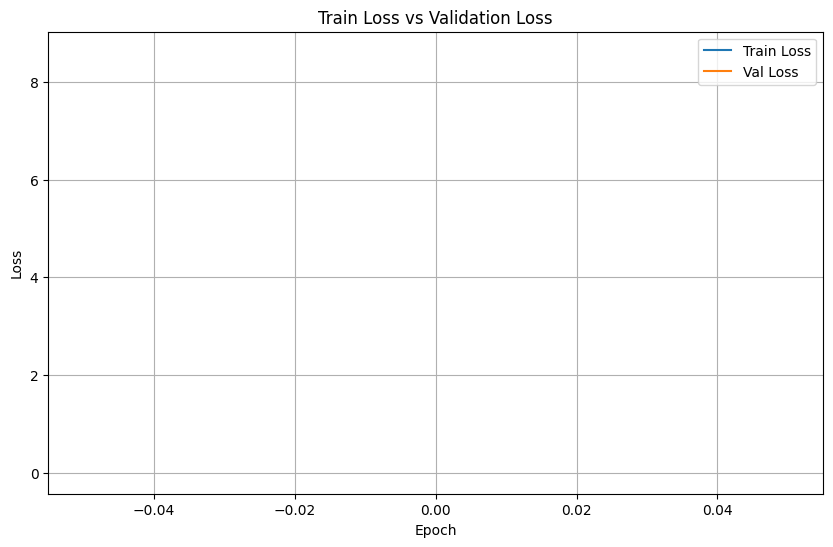

In [ ]:
import matplotlib.pyplot as plt

# Plot Train Loss vs Val Loss
plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import json

output_path = WORKDIR + "/history_mask2former.json"

with open(output_path, "w") as f:
    json.dump(history, f, indent=4)

print("File saved to:", output_path)

File saved to: /workspace/history_mask2former.json


In [ ]:
import torch
from tqdm.auto import tqdm
from torchmetrics import JaccardIndex

def test_model(model, test_loader, device, processor):
    metric = JaccardIndex(
        task="multiclass",
        num_classes=11,
        ignore_index=255,
        average="none"
    ).to(device)

    model.to(device)

    model.eval()
    print("Mulai Testing (menggunakan JaccardIndex)...")

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            list_images = [img for img in images]

            inputs = processor(
                images=list_images,
                return_tensors="pt",
                do_resize=False,
                do_rescale=False
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)

            target_sizes = [(m.shape[0], m.shape[1]) for m in masks]
            pred_maps = processor.post_process_semantic_segmentation(
                outputs, target_sizes=target_sizes
            )
            preds_batch = torch.stack(pred_maps).to(device)
            target_batch = masks.to(device)

            metric.update(preds_batch, target_batch)

    iou_per_class = metric.compute()

    mIoU = iou_per_class.mean().item()

    print("\n=== HASIL TESTING ===")
    print(f"Mean IoU (mIoU): {mIoU:.4f}")
    print("-" * 30)

    class_names = [
        "Background", "Water", "Building No Damage", "Building Minor Damage",
        "Building Major Damage", "Building Total Destruction", "Road-Clear",
        "Road-Blocked", "Vehicle", "Tree", "Pool"
    ]

    for i, iou in enumerate(iou_per_class):
        name = class_names[i] if i < len(class_names) else f"Class {i}"
        print(f"{name:25s}: {iou.item():.4f}")

    metric.reset()
    return mIoU, iou_per_class

In [ ]:
import torch
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor

model_id = "facebook/mask2former-swin-large-ade-semantic"

class_names = [
    "Background", "Water", "Building No Damage", "Building Minor Damage",
    "Building Major Damage", "Building Total Destruction", "Road-Clear",
    "Road-Blocked", "Vehicle", "Tree", "Pool"
]
num_labels = len(class_names)
num_classes_internal = num_labels + 1

processor = Mask2FormerImageProcessor.from_pretrained(
    model_id,
    ignore_index=255,
    do_resize=False,
    do_rescale=False
)

model = Mask2FormerForUniversalSegmentation.from_pretrained(
    model_id,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

ckpt = torch.load(WORKDIR + "/best_model_mask2former.pth", map_location="cpu")

if isinstance(ckpt, dict) and "model" in ckpt:
    ckpt_state = ckpt["model"]
else:
    ckpt_state = ckpt

model_state = model.state_dict()
compatible = {k: v for k, v in ckpt_state.items() if (k in model_state and v.shape == model_state[k].shape)}

print(f"Total model keys: {len(model_state)}; Compatible keys from ckpt: {len(compatible)}; Skipped keys: {len(ckpt_state)-len(compatible)}")

model_state.update(compatible)
model.load_state_dict(model_state)

test_mIoU, test_iou_per_class = test_model(model, test_loader, device, processor)

# print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
# print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
# print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
# print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
# print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n\n\n")
# print(f"===================== IoU Per Class ========================")
# for i, iou in enumerate(test_iou_per_class):
#         name = class_names[i] if i < len(class_names) else f"Class {i}"
#         print(f"{name:25s}: {iou.item():.4f}")

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([12]) in the model instantiated
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([12, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total model keys: 782; Compatible keys from ckpt: 782; Skipped keys: 0
Mulai Testing (menggunakan JaccardIndex)...


Testing:   0%|          | 0/225 [00:00<?, ?it/s]


=== HASIL TESTING ===
Mean IoU (mIoU): 0.6943
------------------------------
Background               : 0.8549
Water                    : 0.8589
Building No Damage       : 0.6991
Building Minor Damage    : 0.5790
Building Major Damage    : 0.5612
Building Total Destruction: 0.6328
Road-Clear               : 0.6394
Road-Blocked             : 0.7677
Vehicle                  : 0.4277
Tree                     : 0.8355
Pool                     : 0.7815


## Testing

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# import os
# from matplotlib.patches import Patch

# CLASS_NAMES = [
#     "Background",
#     "Water",
#     "Building No Damage",
#     "Building Minor Damage",
#     "Building Major Damage",
#     "Building Total Destruction",
#     "Road-Clear",
#     "Road-Blocked",
#     "Vehicle",
#     "Tree",
#     "Pool"
# ]

# LABEL_COLORS = np.array([
#     [0, 0, 0],         # Background
#     [30, 230, 255],    # Water
#     [184, 115, 117],   # Building No Damage
#     [216, 255, 0],     # Building Minor Damage
#     [252, 199, 0],     # Building Major Damage
#     [255, 0, 0],       # Building Total Destruction
#     [140, 140, 140],   # Road-Clear
#     [151, 0, 255],     # Road-Blocked
#     [255, 0, 246],     # Vehicle
#     [0, 255, 0],       # Tree
#     [244, 255, 0]      # Pool
# ])
# def decode_segmap(mask):
#     r = np.zeros_like(mask).astype(np.uint8)
#     g = np.zeros_like(mask).astype(np.uint8)
#     b = np.zeros_like(mask).astype(np.uint8)

#     for l in range(0, len(LABEL_COLORS)):
#         idx = mask == l
#         r[idx] = LABEL_COLORS[l, 0]
#         g[idx] = LABEL_COLORS[l, 1]
#         b[idx] = LABEL_COLORS[l, 2]

#     rgb = np.stack([r, g, b], axis=2)
#     return rgb

# def find_indices_by_filename(dataset, target_ids):
#     found_indices = []
#     for target in target_ids:
#         found = False
#         for idx, path in enumerate(dataset.image_path):
#             if str(target) in os.path.basename(path):
#                 found_indices.append(idx)
#                 found = True
#                 break
#         if not found:
#             return
#     return found_indices

# def visualize_specific_images(model, dataset, target_ids, device, processor):
#     model.eval()

#     indices = find_indices_by_filename(dataset, target_ids)

#     num_samples = len(indices)
#     fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6 * num_samples))

#     if num_samples == 1:
#         axes = axes.reshape(1, -1)

#     for row_idx, idx in enumerate(indices):
#         image, mask = dataset[idx]

#         filename = os.path.basename(dataset.image_path[idx])

#         inputs = processor(
#             images=[image],
#             return_tensors="pt",
#             do_resize=False,
#             do_rescale=False
#         )
#         inputs = {k: v.to(device) for k, v in inputs.items()}

#         with torch.no_grad():
#             outputs = model(**inputs)

#         target_sizes = [(mask.shape[0], mask.shape[1])]
#         pred_map = processor.post_process_semantic_segmentation(
#             outputs, target_sizes=target_sizes
#         )[0]

#         img_np = image.permute(1, 2, 0).numpy()

#         mask_rgb = decode_segmap(mask.numpy())
#         pred_rgb = decode_segmap(pred_map.cpu().numpy())

#         axes[row_idx, 0].imshow(img_np)
#         axes[row_idx, 0].set_title(f"ID: {filename}\nOriginal Image")
#         axes[row_idx, 0].axis("off")

#         axes[row_idx, 1].imshow(mask_rgb)
#         axes[row_idx, 1].set_title("Ground Truth")
#         axes[row_idx, 1].axis("off")

#         axes[row_idx, 2].imshow(pred_rgb)
#         axes[row_idx, 2].set_title("Mask2Former Prediction")
#         axes[row_idx, 2].axis("off")

#     handles = [Patch(color=LABEL_COLORS[i]/255.0, label=CLASS_NAMES[i]) for i in range(len(CLASS_NAMES))]
#     fig.legend(handles=handles, loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.0), fontsize=12)

#     plt.savefig('visualisasi_prediksi_rescuenet.png', bbox_inches='tight', dpi=300)

#     plt.tight_layout()
#     plt.subplots_adjust(bottom=0.08)
#     plt.show()

# target_ids = ["10794", "10801", "10807"]

# visualize_specific_images(model, test_dataset, target_ids, device, processor)

In [ ]:
# model.eval()
# import matplotlib.pyplot as plt

# test_imgs, test_masks = next(iter(test_loader))

# with torch.no_grad():
#     inputs = [{"image": test_imgs[0].to(cfg.MODEL.DEVICE), "height": 512, "width": 512}]

#     outputs = model(inputs)

#     pred_mask = outputs[0]["sem_seg"].argmax(dim=0).cpu().numpy()

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1); plt.title("Prediction"); plt.imshow(pred_mask)
# plt.subplot(1, 2, 2); plt.title("Ground Truth"); plt.imshow(test_masks[0])
# plt.show()